# Technical introduction

Here we introduce the internals of the Earth Hyper-Canny edge detector.

In [1]:
import numpy as np

from scipy import (special, signal, ndimage)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import os
from pathlib import Path

from box import Box, R_earth, DataSet
from plotting import (plot_plate_carree, plot_orthographic_np, plot_mollweide)
from units import unit

# define the box resolution
N = 512
box = Box.generate(N)

# set the figure size
plt.rcParams['figure.figsize'] = (25, 10)

## Gaussian filtering

In [ ]:
test_data = np.zeros(shape=box.shape)
idx = np.linspace(N//4, N//2-8, num=6, dtype='int')
test_data[idx, np.zeros_like(idx)] = 1./np.cos(box.lat[idx] * np.pi / 180.0)

smoothed_test = box.gaussian_filter(test_data, [400*unit.km, 400*unit.km])
value = smoothed_test
value = np.concatenate([value[:, :], value[:, 0:1]], axis=1)

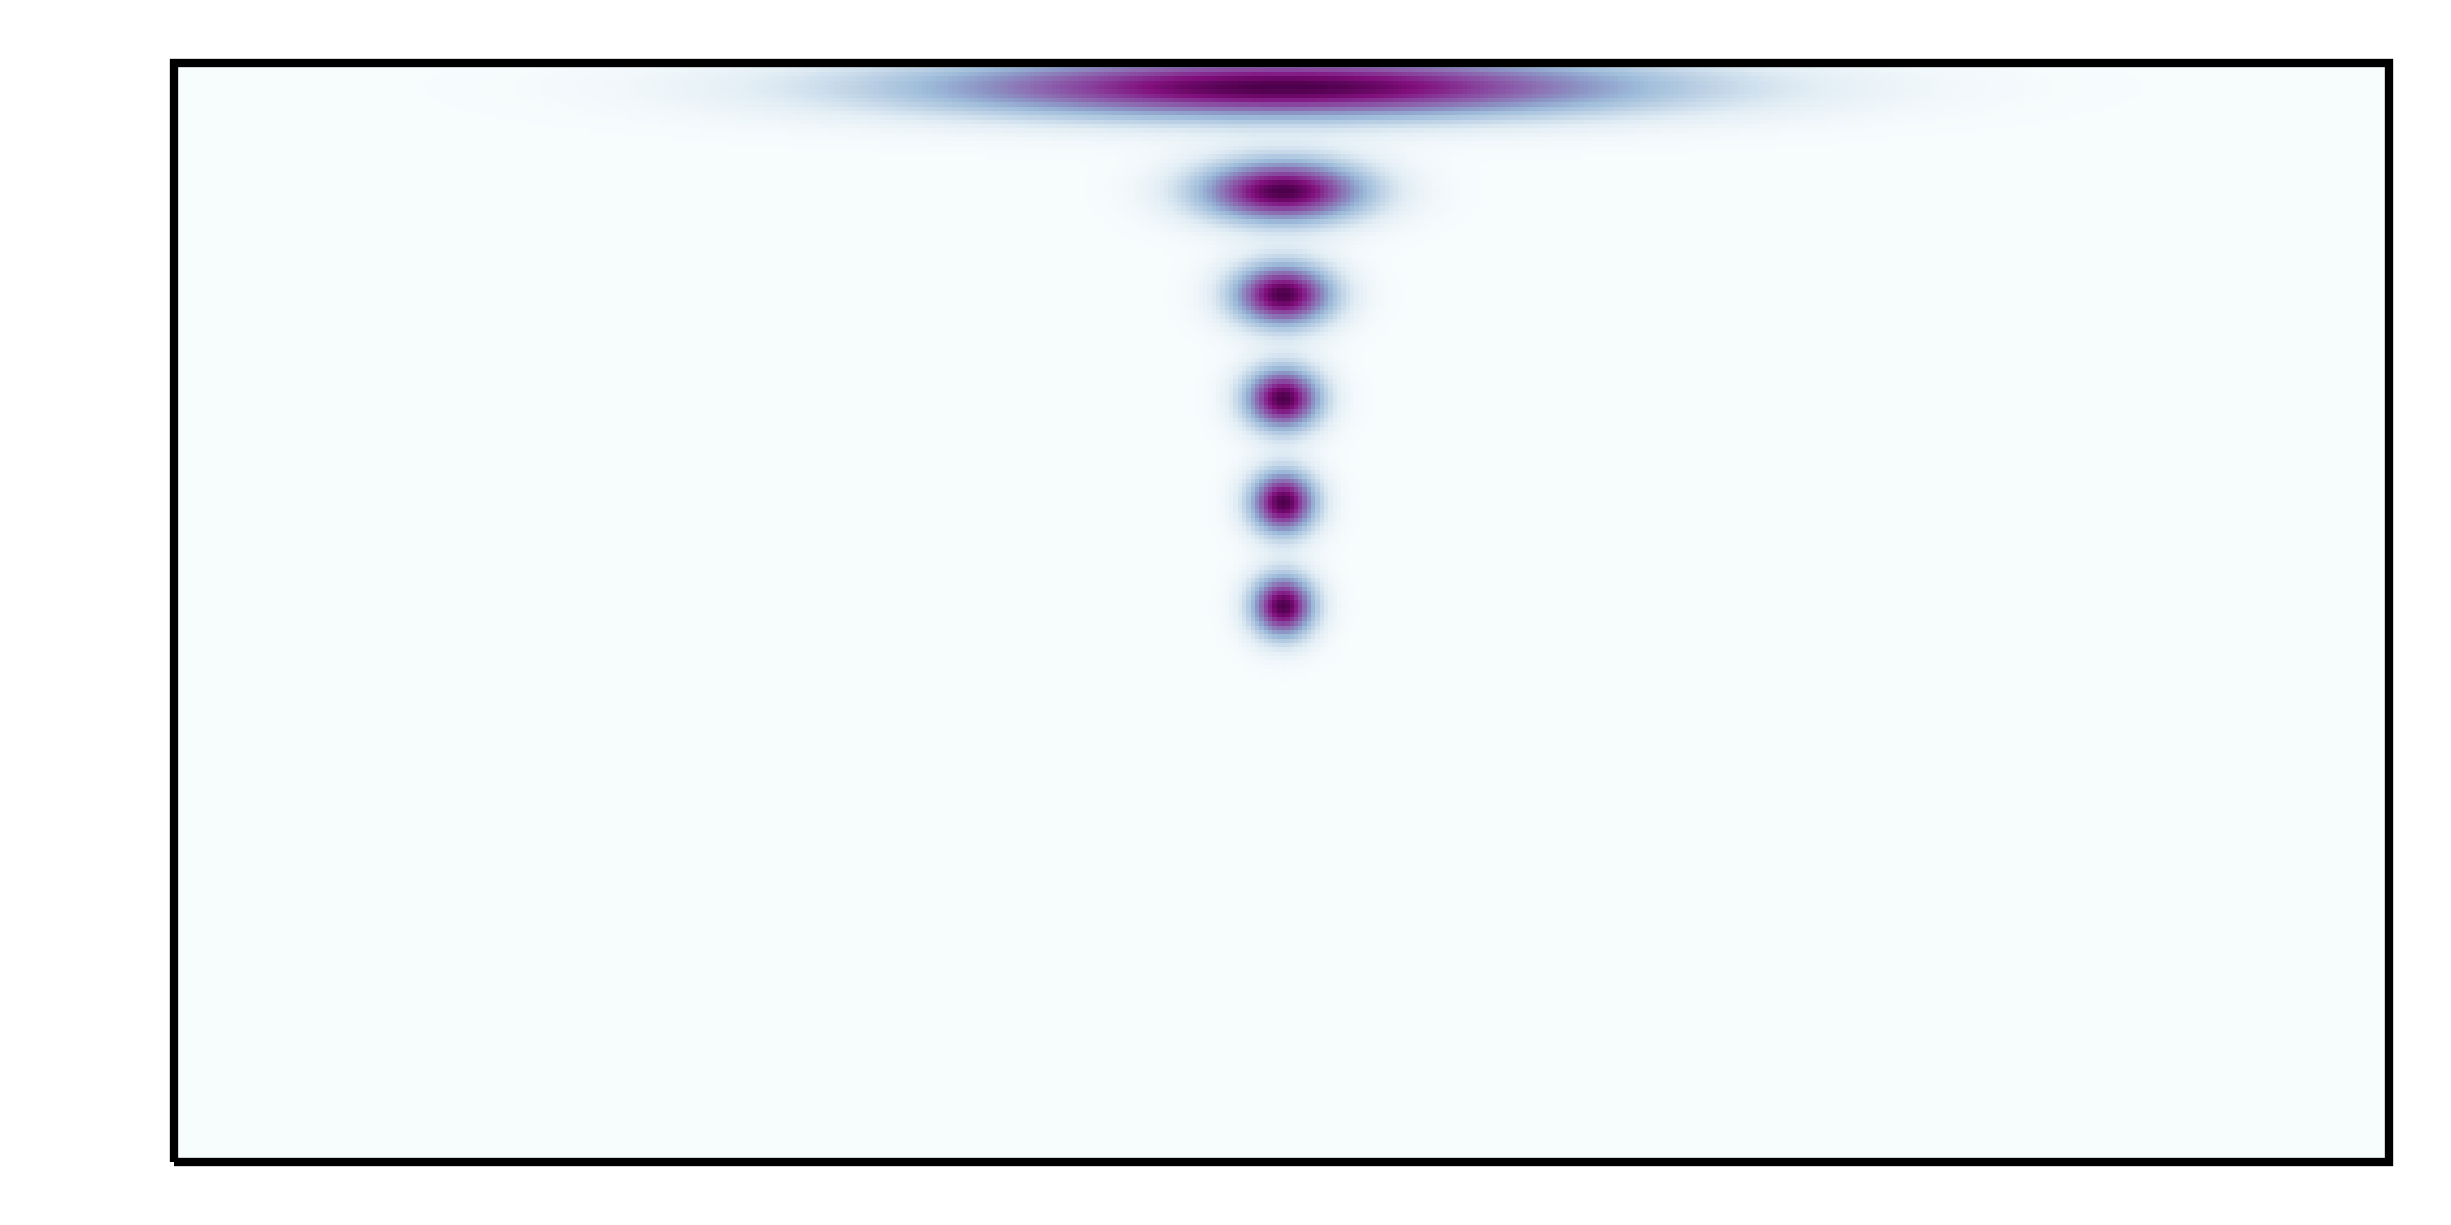

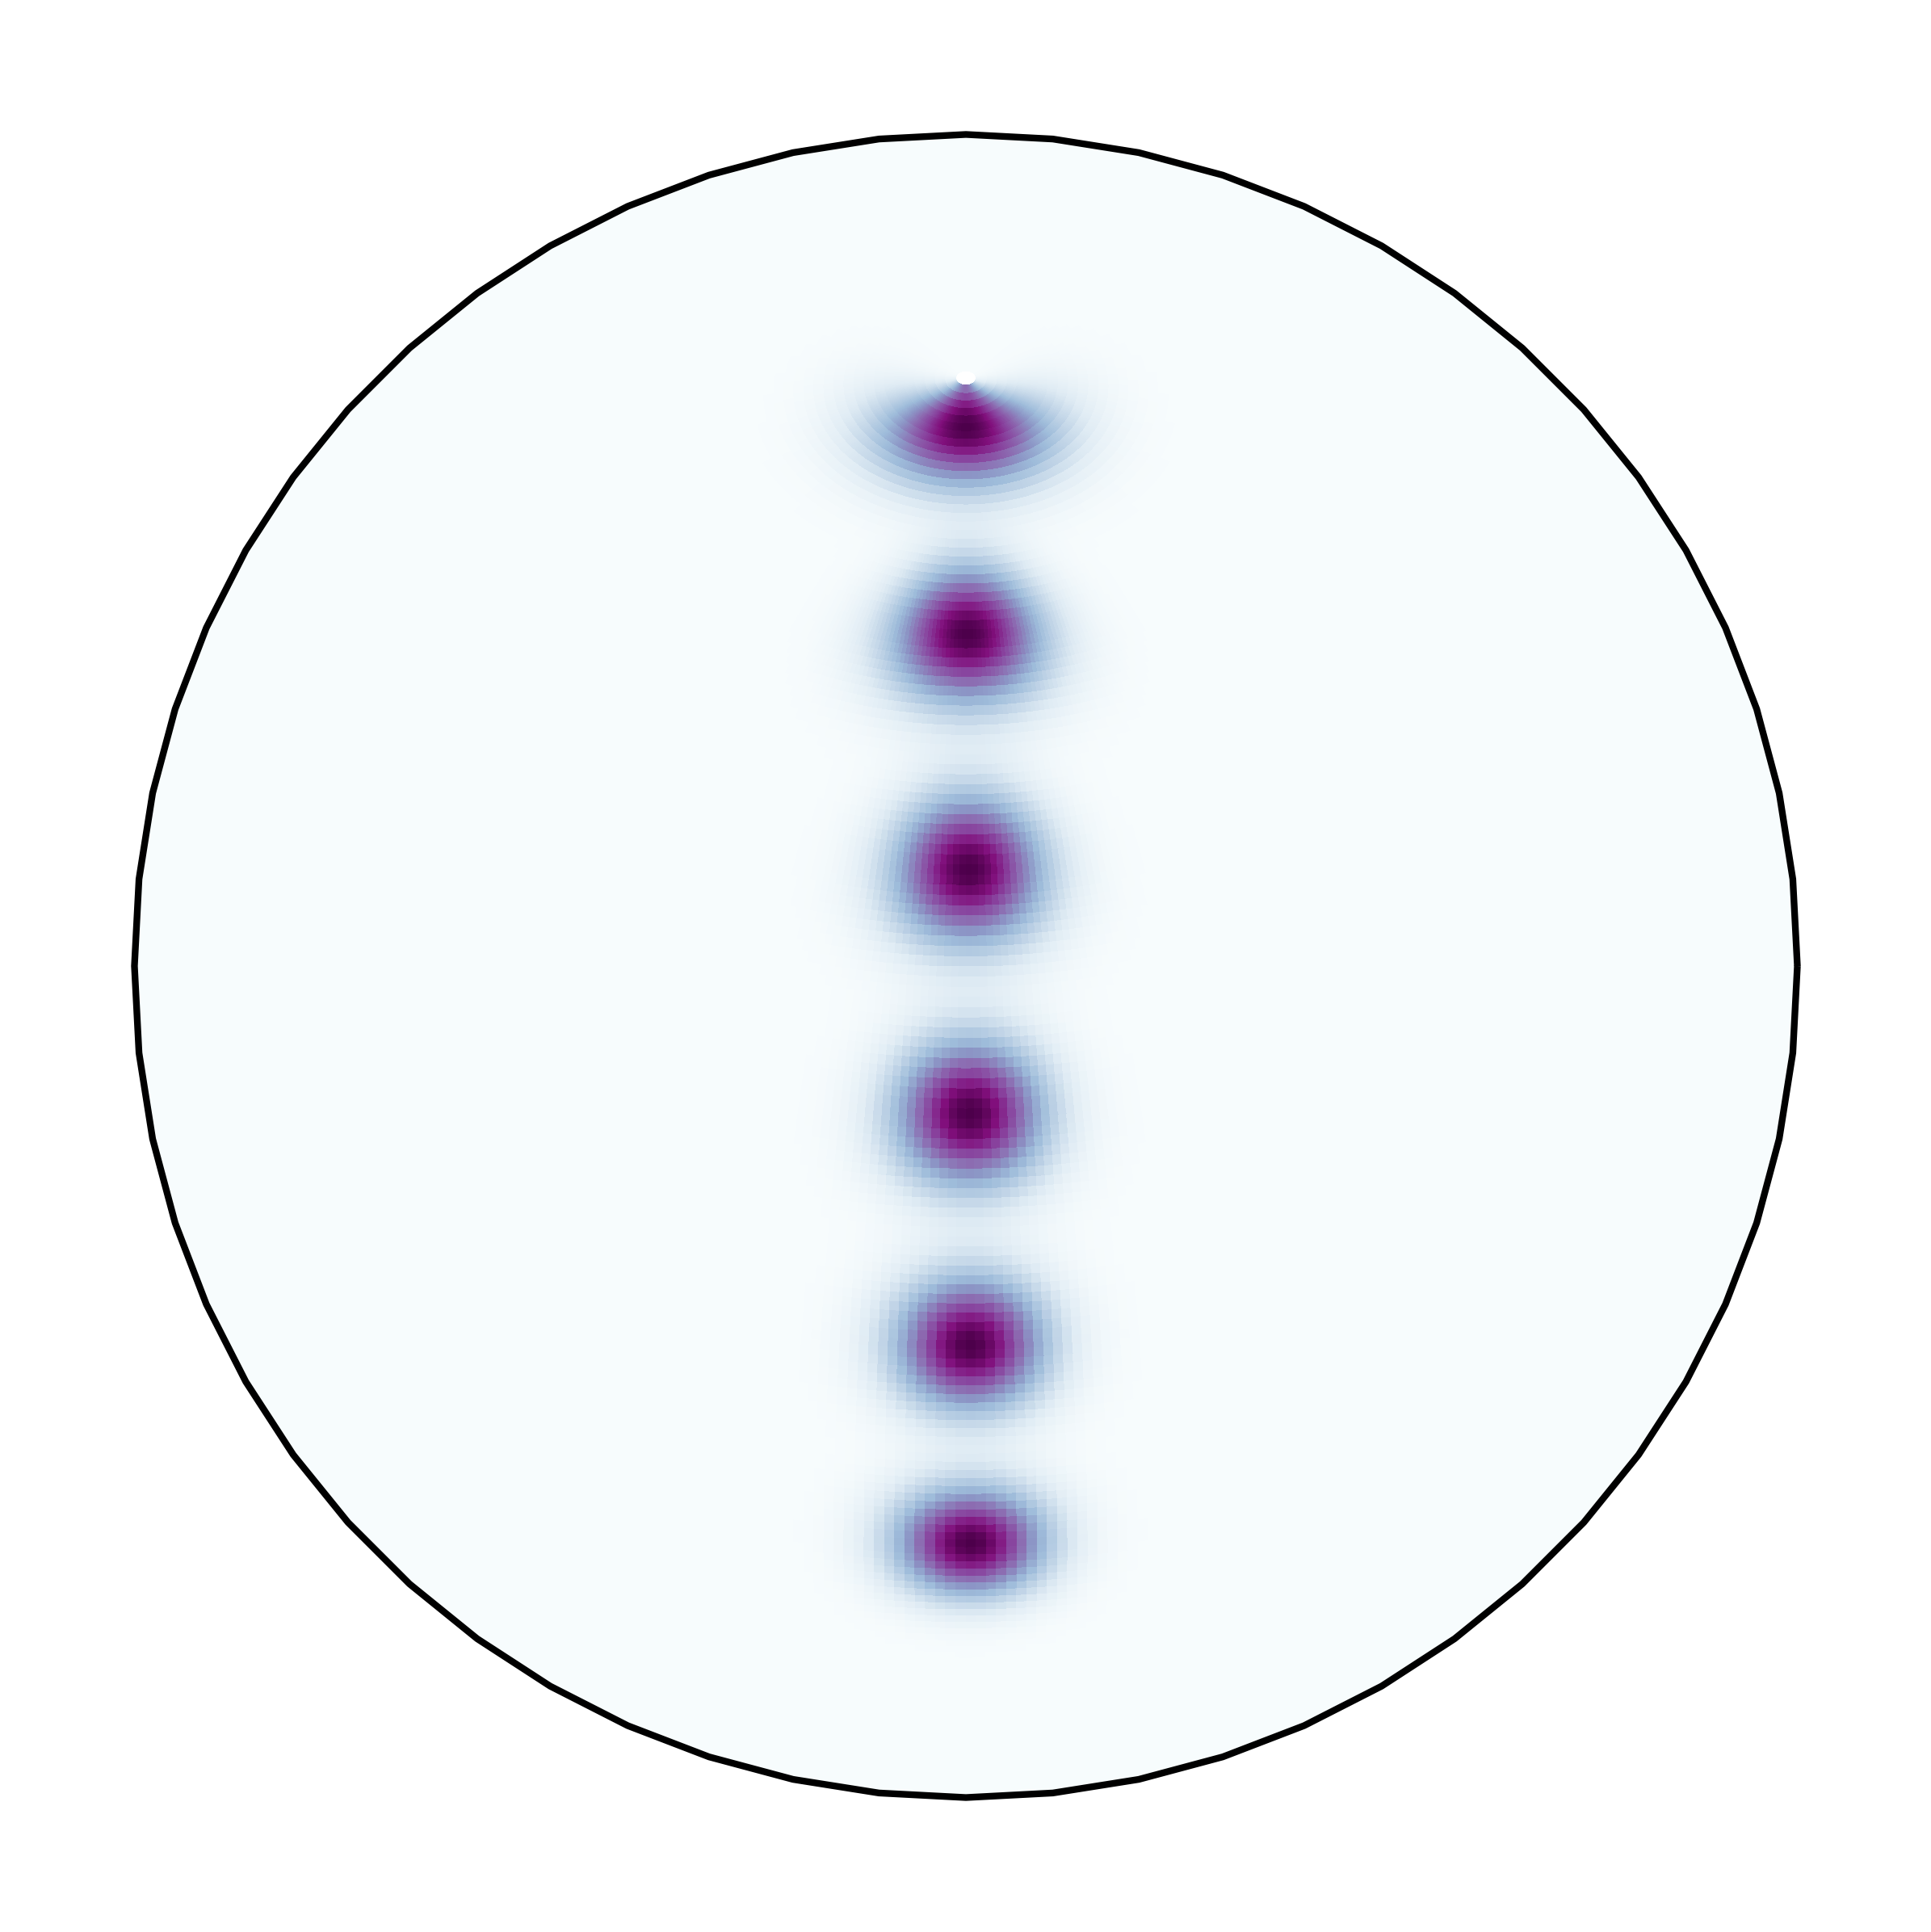

In [48]:
# plot_plate_carree(box, smoothed_test, cmap='Spectral_r')
# plt.imshow(test_data)
projection=ccrs.PlateCarree()
transform=ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90)
lons = box.lon.copy()
lons = np.concatenate([lons, lons[0:1]])
lats = box.lat.copy()

fig = plt.figure(figsize=(5, 5), dpi=600, frameon=False)
ax = fig.add_subplot(111, projection=projection, frame_on=False)
pcm = ax.pcolormesh(
    lons, lats, value, cmap='BuPu',
    transform=transform)
ax.axis('off')
plt.savefig('spheres-rect.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 5), dpi=600, frameon=False)
projection=ccrs.Orthographic(central_latitude=45)
ax = fig.add_subplot(111, projection=projection)
pcm = ax.pcolormesh(
    lons, lats, value, cmap='BuPu',
    transform=transform)
ax.axis('off')
plt.savefig('spheres-ortho.png', bbox_inches='tight')
plt.show()

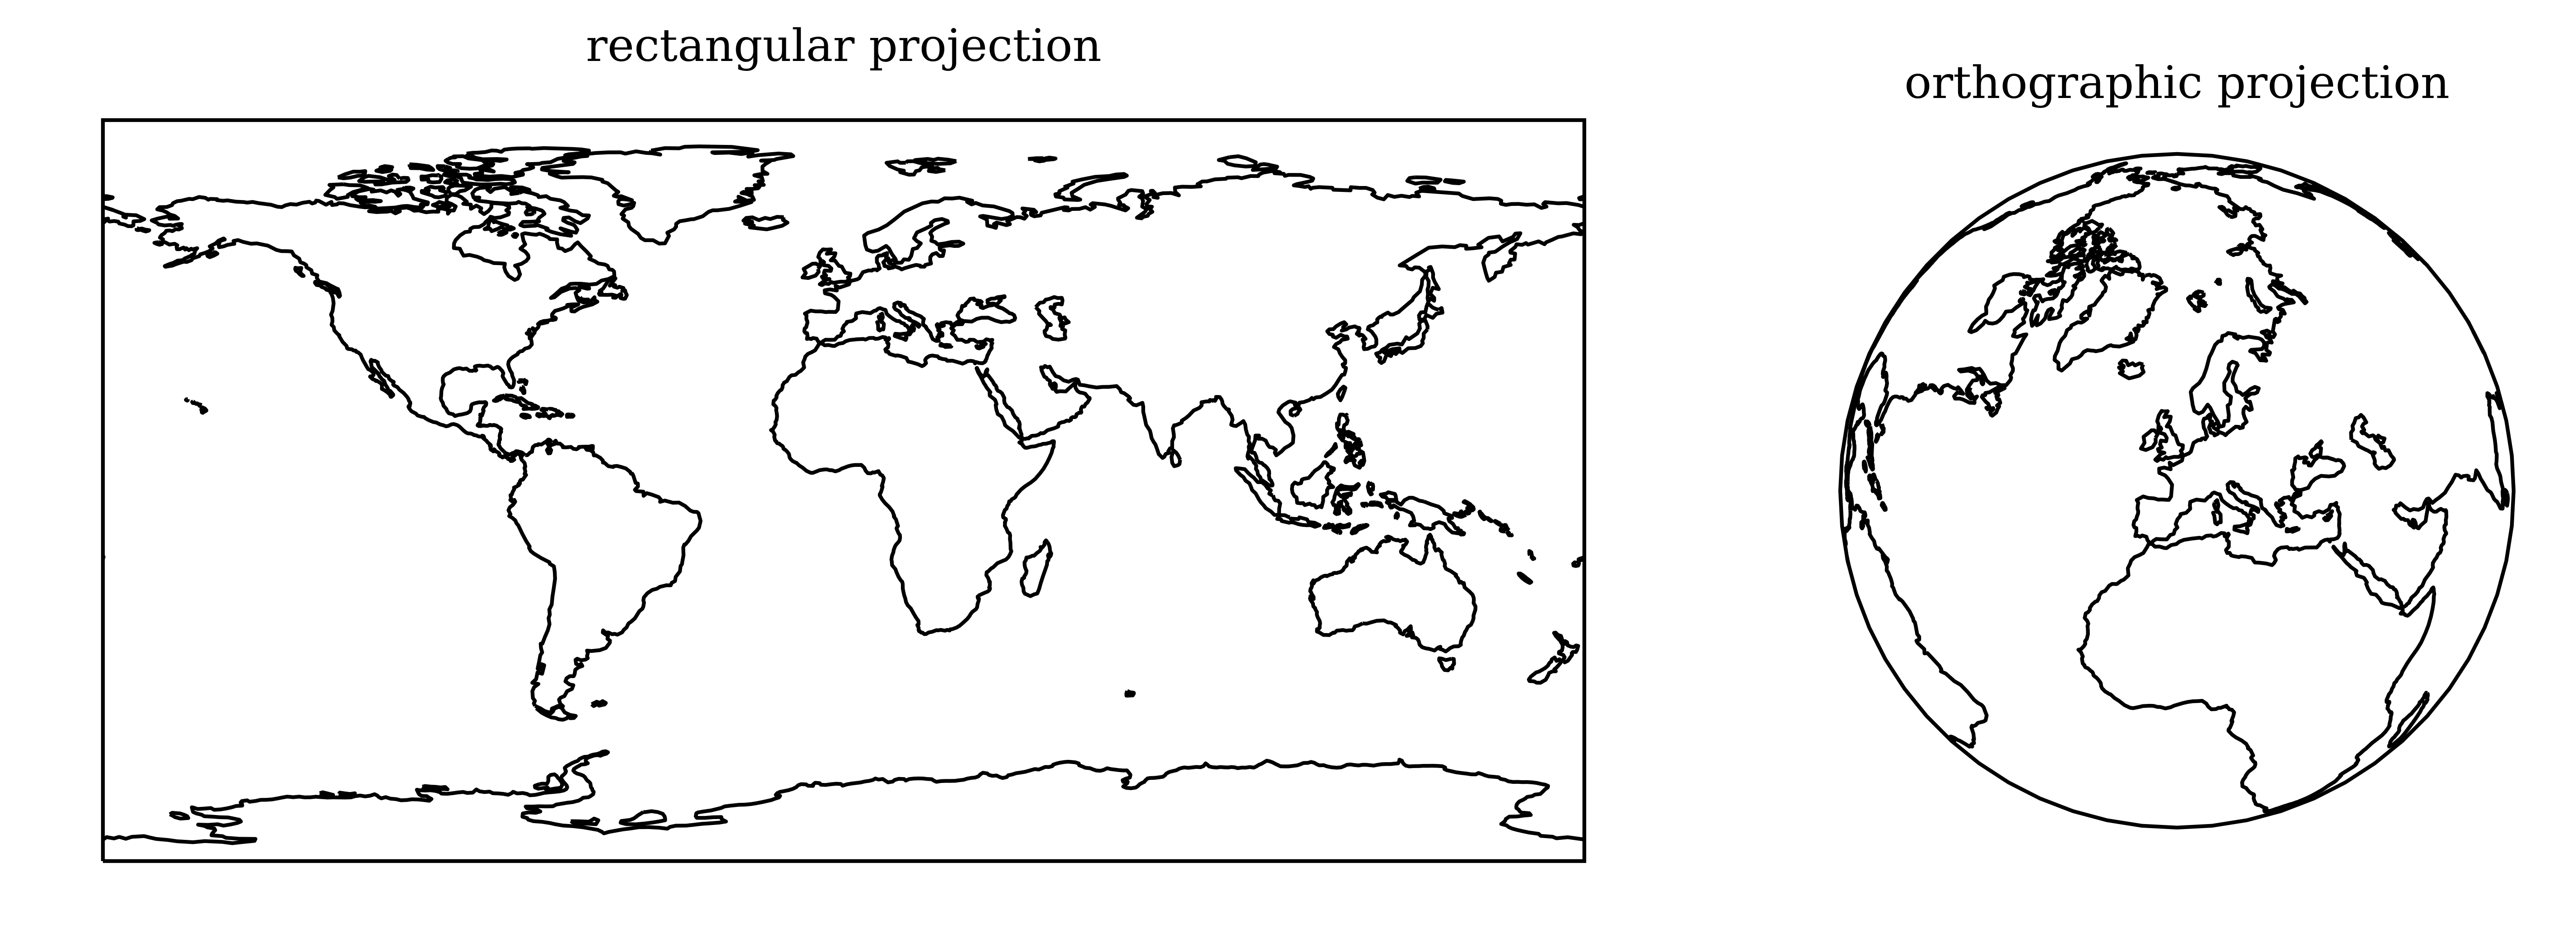

In [30]:
# plot_plate_carree(box, smoothed_test, cmap='Spectral_r')
# plt.imshow(test_data)
plt.rcParams['font.family'] = 'serif'
projection=ccrs.PlateCarree()
transform=ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90)
lons = box.lon.copy()
lons = np.concatenate([lons, lons[0:1]])
lats = box.lat.copy()

fig = plt.figure(figsize=(12, 7), dpi=600)
ax = plt.subplot2grid((1, 3), (0, 0), projection=projection, colspan=2)
ax.coastlines()
ax.set_title('rectangular projection')

projection=ccrs.Orthographic(central_latitude=45)
ax = plt.subplot2grid((1, 3), (0, 2), projection=projection, colspan=1)
ax.coastlines()
ax.set_title('orthographic projection')
plt.savefig('spheres-coastlines.svg', bbox_inches='tight')
plt.show()

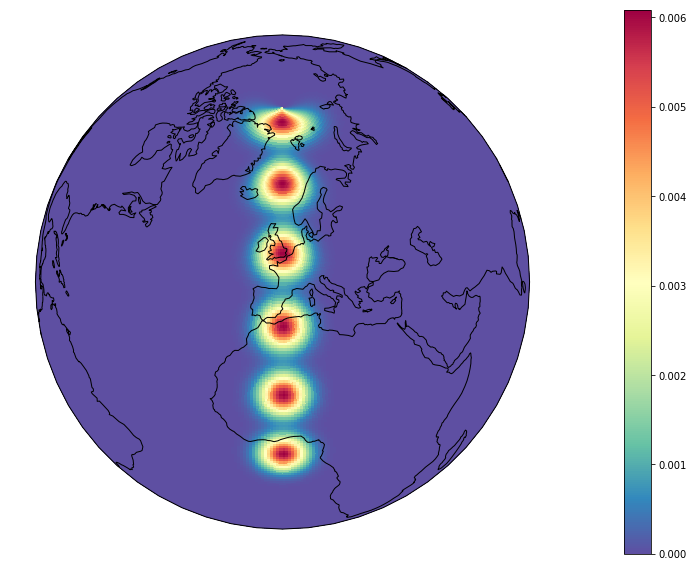

In [3]:
plot_orthographic_np(
        box, smoothed_test,
        central_latitude=45, cmap='Spectral_r')

In [4]:
smoothed_test[idx, 0].std()

5.324377010099454e-08

## Sobel operator, differentials and homogeneous coordinates

In [5]:
def f(lat, lon):
    l = 3
    m = 2
    lon_rad = lon / 180. * np.pi
    lat_rad = (lat + 90) / 180. * np.pi
    return special.sph_harm(m, l, lon_rad[None, :], lat_rad[:, None]).real

def df_sph(lat, lon, h=0.001):
    df0 = (f(lat + h, lon) - f(lat - h, lon)) / (2 * h)
    df1 = (f(lat, lon + h) - f(lat, lon - h)) / (2 * h)
    return df0, df1

df0, df1 = df_sph(box.lat, box.lon)

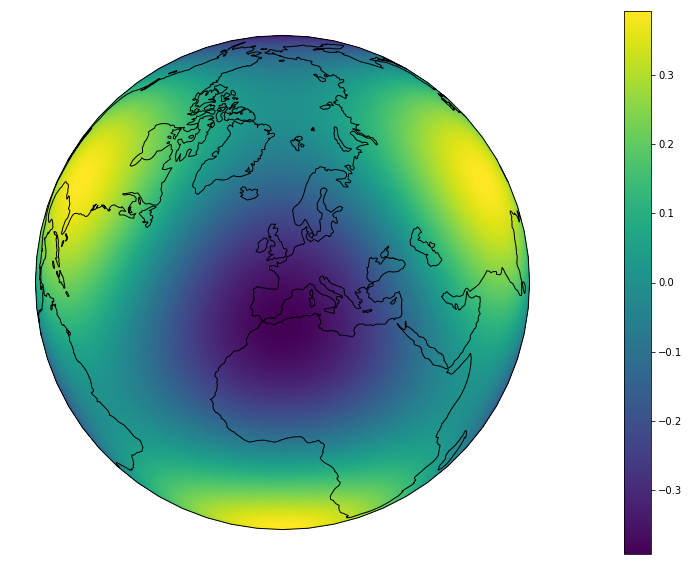

In [6]:
plot_orthographic_np(box, f(box.lat, box.lon), central_latitude=45)

In [7]:
test_data = f(box.lat, box.lon)
test_sobel = box.sobel_filter(test_data, physical=True)
test_sobel[2] *= 360 / N

print("max error 0:", ((test_sobel[0]/test_sobel[2] - df0)**2).max())
print("mean error 0:", ((test_sobel[0]/test_sobel[2] - df0)**2).mean())
print("max error 1:", ((test_sobel[1]/test_sobel[2] - df1)**2).max())
print("mean error 1:", ((test_sobel[1]/test_sobel[2] - df1)**2).mean())

max error 0: 1.20104198121e-08
mean error 0: 5.36185401021e-11
max error 1: 6.23051624545e-05
mean error 1: 1.13348814733e-05


## Mask tapering

In [12]:
data_folder = Path("/mnt/Knolselderij/bulk/Abrupt/")
month = 3

sigma_d = unit('200 km')
sigma_t = unit('5 year')

gamma = 1
scaling_factor = gamma * unit('10 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

data_set = DataSet(
    path=data_folder,
    model = 'HadGEM2-ES',
    variable = 'mrso',
    scenario='rcp85',
    realization='r1i1p1',
)

data_set.load()

In [14]:
data = data_set.data
data_set.box.taper_masked_area(data, [0, 5, 5], 50)

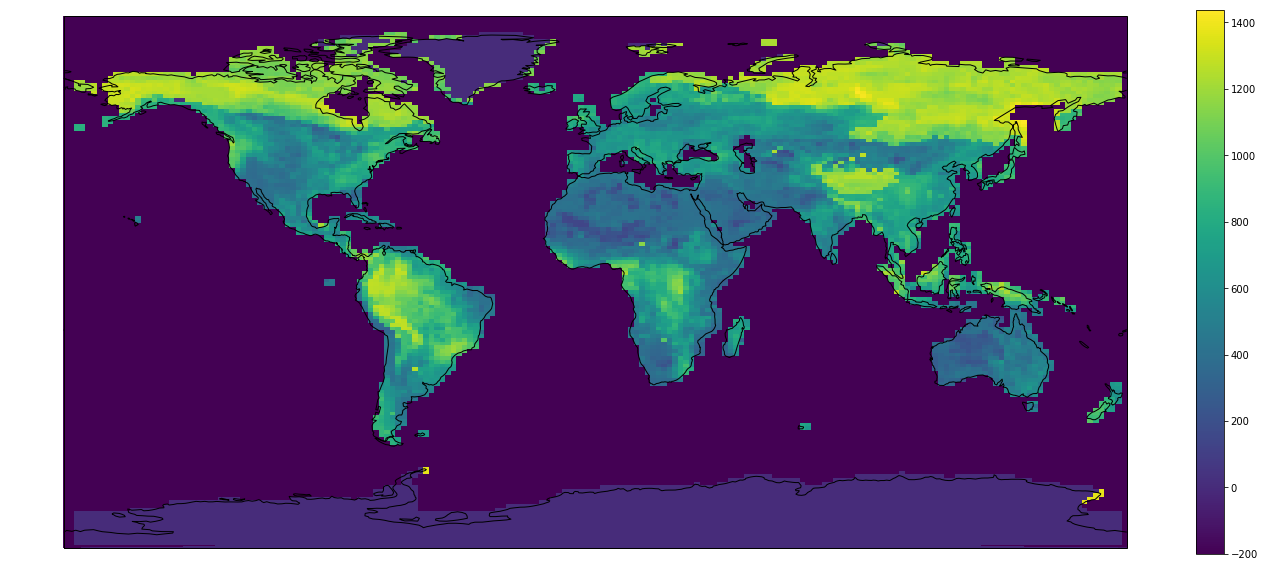

In [17]:
plot_plate_carree(data_set.box, data[0].filled(-200))

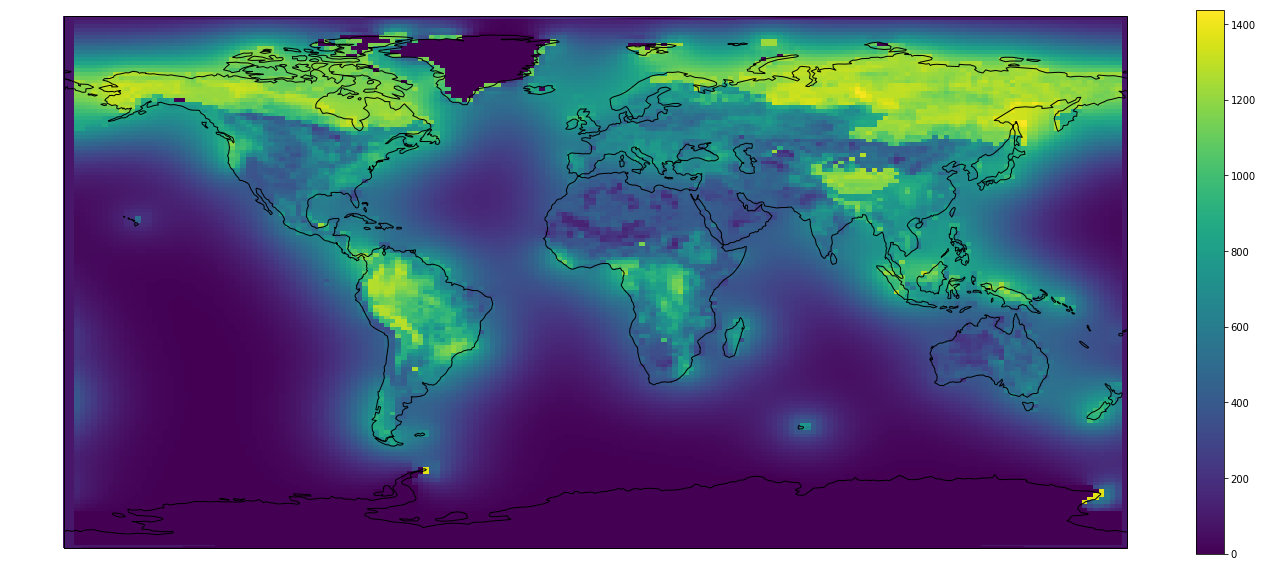

In [16]:
plot_plate_carree(data_set.box, data[0])